<a href="https://colab.research.google.com/github/jembi/mpi-toolkit-notebook/blob/fastlink_dedupe/fastLink-notebook/Dedupe/Fastlink_R_Deduplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

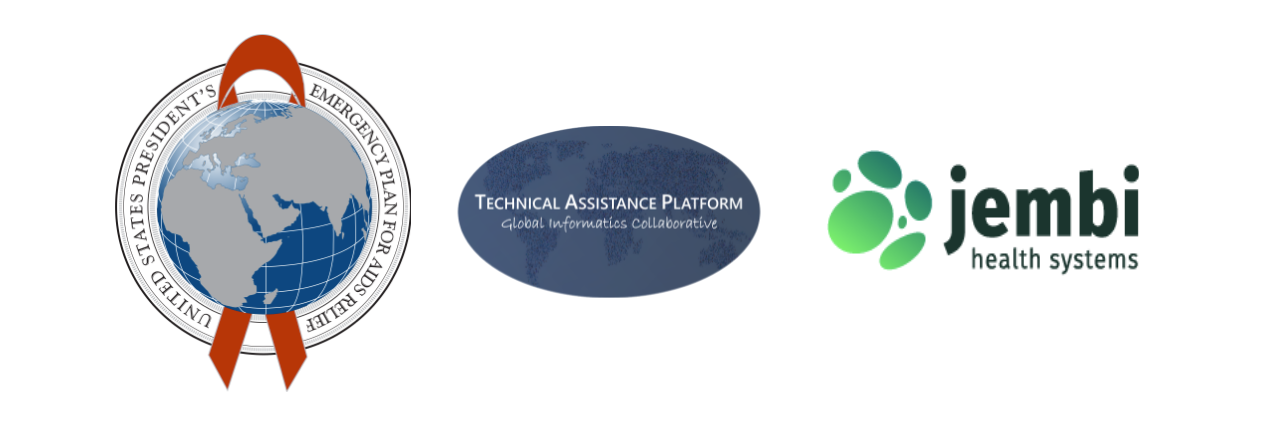

# **<font color="#007f68"> Fastlink_R (Deduplication) Notebook**

Fastlink is an implementation of the traditional Fellegi-Sunter approach to record linkage. This deduplication approach uses comparisons of the shared fields between records within a single dataset (ie, first name, last name, year of birth, month of birth, day of birth, gender, and race) to compute the conditional probability that each record pair is a match. Record pairs are classified as matches or nonmatches based on thresholding these conditional probabilities. 

## <font color="#007f68">Links to other MPI-toolkit Notebooks:
[Directory](https://colab.research.google.com/drive/1TqQ5sklvhw8I1f5m49ob-WTFfBtiElfs#scrollTo=M5NmyYErfDvt)

[Data Generator](https://colab.research.google.com/drive/1f1nnThx7sV47R_bbHq8CIlBfTVrcM2NA#scrollTo=9cXT_RyoLtv3%23offline%3Dtrue&sandboxMode=true)

[Blocking](https://colab.research.google.com/drive/1fB6pa8Xu1cMdf1VmnTZ7bn5j-TS_ccRO#scrollTo=cbBPp8a-1ou5&forceEdit=true&sandboxMode=true)


[Fastlink R Linking](https://colab.research.google.com/drive/198Du0EOpaFODRmgLoIV_9a7XYYV2Um-u#scrollTo=isUSuVAs37Al)

## **<font color="#007f68">1. Notebook Setup**

Run the following 2 code blocks to prime the notebook and import the necessary libraries in use.

Installations and imports are only needed to be executed once per session.

In [ ]:
#@title <font color="#18CF68">1.1) Installations
menu_list = ["1.1) Installations", "1.2) Imports", 
             "2.1) Pick method of uploading csv file", 
             "2.2) Select desired datafile", "2.3) Upload and read data", 
             "3.1) Capture User input", "3.2) Run fastlink", 
             "4.1) Display results", "4.2) Recall, precision and F_score results", 
             "4.3) Display M and U values", 
             "4.4) Update data to a Google Spreadsheet"]
def tracker_err_msg(tracker, cell_id):
  print("Please execute code cell(s) from \n'" + menu_list[tracker + 1] + 
        "' \nup to the \n'" + menu_list[cell_id] + "'\n cell before continuing!")
tracker = 0
!pip install -q rpy2
!pip install -q --upgrade gspread

In [ ]:
#@title <font color="#18CF68">1.2) Imports
cell_id = 1
if tracker >= (cell_id - 1):
  import pandas as pd
  import os
  import time
  from IPython.utils import io

  # Import rpy2 packages
  from rpy2.robjects import globalenv
  from rpy2.robjects.vectors import StrVector
  import rpy2.robjects as r_objects
  import rpy2.robjects.packages as r_packages
  r = r_objects.r

  from ipywidgets import Dropdown, FloatSlider, Text, GridBox, Checkbox, Label, FloatRangeSlider

  import matplotlib.pyplot as plt
  from google.colab import auth
  import gspread
  from oauth2client.client import GoogleCredentials
  run_count = 1

  # Fastlink imports
  with io.capture_output() as captured:
    utils = r_packages.importr('utils')
    utils.chooseCRANmirror(ind=1)
    pack_names = ('fastLink', 'tictoc', 'strex', 'data.table', 'csv')
    names_to_install = [x for x in pack_names if not r_packages.isinstalled(x)]
    if len(names_to_install) > 0:
      utils.install_packages(StrVector(names_to_install))
    base = r_packages.importr('base')
    stats = r_packages.importr('stats')
    fastLink = r_packages.importr('fastLink')
    strex = r_packages.importr('strex')
    data_table = r_packages.importr('data.table')
    stringr = r_packages.importr('stringr')
    
  tracker = cell_id
else:
  tracker_err_msg(tracker, cell_id)

## **<font color="#007f68">2. Upload csv file for deduplication**

In [ ]:
#@title <font color="#18CF68">2.1) Pick method of uploading csv file
cell_id = 2
if tracker >= (cell_id - 1):
  file_option = menu_1 = Dropdown(options=['Upload from google drive', 'Upload local file', "Use sample dataset"])
  display(file_option)
  tracker = cell_id
else:
  tracker_err_msg(tracker, cell_id)

Dropdown(options=('Upload from google drive', 'Upload local file', 'Use sample dataset'), value='Upload from g…

In [ ]:
#@title <font color="#18CF68">2.2) Select desired datafile
cell_id = 3
if tracker >= (cell_id - 1):  
  if file_option.value == "Upload from google drive":
    from google.colab import drive
    drive.mount('/content/drive')
    style = {'description_width': 'initial'}
    layout = {'width': '400px'}
    file_name = Text(
      style=style,
      layout=layout,
      value='data-50-25.csv',
      description='Enter file name:',
      disabled=False)
    folder_name = Text(
      style=style,
      layout=layout,
      value='/content/drive/MyDrive/Data Generator/',
      description='Enter folder directory:',
      disabled=False)
    display(file_name, folder_name)
  elif file_option.value == "Upload local file":
    from google.colab import files
    uploaded = files.upload()
    file_list = list(uploaded.keys())
    file = file_list[0]
  else:
    df = pd.read_csv("https://raw.githubusercontent.com/jembi/mpi-toolkit-notebook/main/fastLink-notebook/data-200-100.csv")
    df.to_csv('sample_dataset.csv', index=False)
    file = 'sample_dataset.csv'
    print("Using sample dataset: 200 original, 100 duplicates")

  tracker = cell_id
else:
  tracker_err_msg(tracker, cell_id)

Saving data-10000-05000-dcab.csv to data-10000-05000-dcab.csv


In [ ]:
#@title <font color="#18CF68">2.3) Upload and read data
cell_id = 4
if tracker >= (cell_id - 1): 
  if file_option.value == "Upload from google drive":
    file = folder_name.value + file_name.value
  
  try:
    globalenv['csv'] = r['read.csv'](file, header=True, stringsAsFactors=False)
    col_names_r = r('colnames(csv)')
    col_names = list(col_names_r)
    r('csv[csv==""] <- NA')
    r('dfA <- csv[str_detect(csv$ID, "-aaa-"), ]')
    r('dfB <- csv[str_detect(csv$ID, "-bbb-"), ]')
    s = r('structure(list(csv = csv, dfA = dfA, dfB = dfB))')

    r('write.csv(csv, file="file.csv")')
    file = pd.read_csv('file.csv')
    display(file)
    try:
      os.remove('file.csv')
    except OSError:
      pass
    tracker = cell_id
  except: # Add specific exception error
    print("Cannot find such file")
else:
  tracker_err_msg(tracker, cell_id)


## **<font color="#007f68">3. Fastlink**

1. Select the field/attribute that will act as the unique ID for each record.
2. Select the fields that you would like to be **excluded** from the Fastlink run.
3. Choose the string-distance method you want to apply to all fields when comparing records.

  - Jaro - Jaro Similarity is the measure of similarity between two strings. The value of Jaro distance ranges from 0 to 1. where 1 means the strings are equal and 0 means no similarity between the two strings. 

  - Jaro-Winkler - The Jaro-Winkler similarity is a string metric measuring edit distance between two strings. Jaro – Winkler Similarity is much similar to Jaro Similarity. They both differ when the prefix of two string match. Jaro – Winkler Similarity uses a prefix scale ‘p’ which gives a more accurate answer when the strings have a common prefix up to a defined maximum length l. 

  - Levenshtein - The Levenshtein distance is a string metric for measuring the difference between two sequences. Informally, the Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other.

4. Choose the partial match's upper and lower thresholds. If the string-distance score is lower than or equal to the lower threshold it will assign a unmatch weight i.e. log2((1-m)/(1-u)) to the field score. A string-distance score above the upper threshold will assign a match weight i.e. log(m/u) to the field. If string distance score is in between the thresholds i.e, is a partial match, then the weight that this field contributes to the total score is equal to log(m/u) * gamma.

In [ ]:
#@title <font color="#18CF68">3.1) Capture User input
cell_id = 5
if tracker >= (cell_id - 1):   
  style = {'description_width': 'initial'}
  layout = {'width': '400px'}
  menu_1 = Dropdown(description="1. Choose your unique identifier:", style=style, options=col_names)
  display(menu_1)

  check_b_label = Label(value="2. Choose desired fields to exclude:")
  display(check_b_label)

  check_b_list = []
  for i in range(len(col_names)):
    if col_names[i] == menu_1.value:
      check_b = Checkbox(value=True, description=col_names[i], disabled=False, indent=False)
    else:
      check_b = Checkbox(value=False, description=col_names[i], disabled=False, indent=False)
    check_b_list.append(check_b)
    display(check_b)

  menu_2 = Dropdown(layout=layout, description="3. Choose your string-distance method:", style=style, options=["Jaro-Winkler", "Jaro", "Levensthein"])
  display(menu_2)

  slider_label = Label(value="4. Select upper and lower bounds:")
  display(slider_label)

  slider_1 = FloatRangeSlider(
      value=[0.88, 0.94],
      min=0,
      max=1,
      step=0.01,
      disabled=False,
      continuous_update=False,
      orientation='horizontal',
      readout=True,
      readout_format='.2f',
  )
  display(slider_1)
  tracker = cell_id
else:
  tracker_err_msg(tracker, cell_id)


Dropdown(description='1. Choose your unique identifier:', options=('source_system_id', 'first_name', 'last_nam…

Label(value='2. Choose desired fields to exclude:')

Checkbox(value=True, description='source_system_id', indent=False)

Checkbox(value=False, description='first_name', indent=False)

Checkbox(value=False, description='last_name', indent=False)

Checkbox(value=False, description='gender', indent=False)

Checkbox(value=False, description='dob', indent=False)

Checkbox(value=False, description='city', indent=False)

Checkbox(value=False, description='phone_number', indent=False)

Checkbox(value=False, description='national_id', indent=False)

Dropdown(description='3. Choose your string-distance method:', layout=Layout(width='400px'), options=('Jaro-Wi…

Label(value='4. Select upper and lower bounds:')

FloatRangeSlider(value=(0.88, 0.94), continuous_update=False, max=1.0, step=0.01)

In [ ]:
#@title <font color="#18CF68">3.2) Run fastlink
cell_id = 6
if tracker >= (cell_id - 1):
  s_time = time.time()
  key = menu_1.value
  key_position = menu_1.index + 1
  string_distance = menu_2.value
  if string_distance == "Jaro-Winkler":
    string_distance = "jw"
  elif string_distance == "Jaro":
    string_distance = "jaro"
  else:
    string_distance = "lv"
  cut_a = slider_1.value[0]
  cut_p = slider_1.value[1]

  param_exclde_list = []
  for i in range(len(check_b_list)):
    if check_b_list[i].value == True:
      param_exclde_list.append(check_b_list[i].description)

  param_exclde_str = "'"
  for k in range(len(param_exclde_list)):
    if k < len(param_exclde_list) - 1:
      param_exclde_str = param_exclde_str + param_exclde_list[k] + "', '"
    else:
      param_exclde_str = param_exclde_str + param_exclde_list[k] + "' "

  df_a = s
  def fl_dedupe(df_a, exclded_fields, string_distance, cut_a, cut_p):
          get_dedupes = r('''
              my_fl_dedupe <- function(df_a) {{        
                  pasteT <- function(x) {{
                      x <- sort(x)
                      x <- paste(x, collapse = ",")
                      x
                  }}
                  varnames      <- colnames(csv)
                  varnames      <- varnames[-which(varnames %in% c({0}))]
                  invisible(capture.output(fl_out <- fastLink(dfA = csv, dfB = csv, varnames = varnames,
                                            stringdist.match = varnames, stringdist.method = '{1}', cut.a = {2}, 
                                            cut.p = c(0.80, {3}), dedupe.matches = TRUE, linprog.dedupe = FALSE,
                                            cond.indep = 'TRUE',
                                            n.cores = 8,
                                            verbose = 'TRUE')))
                  inds_ab <- data.table(cbind(fl_out$matches$inds.a, fl_out$matches$inds.b))
                  inds_ab[, `:=`(V3, pasteT(V2)), by = V1]
                  inds_ab <- inds_ab[,.(V1, V3)]
                  inds_ab <- inds_ab[!duplicated(inds_ab)]
                  setnames(inds_ab, 'V3', 'V2')
                  inds_ab <- unique(inds_ab[,list(V2)])
                  structure(list(fl_out = fl_out, inds_ab = inds_ab))
              }}
              '''.format(exclded_fields, string_distance, cut_a, cut_p))
          return get_dedupes(df_a)

  def analytics(process):
    varnames = tuple(globalenv['{0}'.format(process)].rx2('fl_out').rx2('EM').rx2('varnames'))
    em_p_gamma_k_m = []
    for i in range(len(r('{0}$fl_out$EM$p.gamma.k.m'.format(process)))):
      placeholder = ['p.gamma.k.m ----- %-20s : %3.10f  %3.10f  %3.10f',
                      varnames[i],
                      r('{0}$fl_out$EM$p.gamma.k.m'.format(process))[i][0],
                      abs(r('{0}$fl_out$EM$p.gamma.k.m'.format(process))[i][1]),
                      r('{0}$fl_out$EM$p.gamma.k.m'.format(process))[i][0] + r('{0}$fl_out$EM$p.gamma.k.m'.format(process))[i][1]]
      em_p_gamma_k_m.append(placeholder)
    em_p_gamma_k_u = []
    for i in range(len(r('{0}$fl_out$EM$p.gamma.k.u'.format(process)))):
      placeholder = ['p.gamma.k.u ----- %-20s : %3.10f  %3.10f  %3.10f',
                      varnames[i],
                      abs(r('{0}$fl_out$EM$p.gamma.k.u'.format(process))[i][0]),
                      r('{0}$fl_out$EM$p.gamma.k.u'.format(process))[i][1],
                      r('{0}$fl_out$EM$p.gamma.k.u'.format(process))[i][0] + r('{0}$fl_out$EM$p.gamma.k.u'.format(process))[i][1]]
      em_p_gamma_k_u.append(placeholder)
    return varnames, em_p_gamma_k_m, em_p_gamma_k_u

  if len(param_exclde_list) != len(col_names):
    try:
      globalenv['dedupes'] = fl_dedupe(df_a, param_exclde_str, string_distance, cut_a, cut_p)
      log_info = analytics('dedupes')
      varnames = log_info[0]
      em_p_gamma_k_m = log_info[1]
      em_p_gamma_k_u = log_info[2]
      v2 = tuple(r('dedupes$inds_ab$V2'))
      tracker = cell_id

      fields = tuple(col_names)
      left = pd.DataFrame(columns=('key',) + fields)
      right = pd.DataFrame(columns=('key',) + fields)
      k = 0
      max_no_dup = 0

      for i in range(len(v2)):
        dupe_links = tuple(map(int, v2[i].split(',')))
        if len(dupe_links) > max_no_dup:
          max_no_dup = len(dupe_links)
        dup = []
        master = r('csv[{},]'.format(dupe_links[0]))
        for j in range(1, len(dupe_links)):
          count_1 = 0
          for u in range(len(master)):
            if str(master.rx2(u + 1)[0]) == "NA":
              count_1 += 1

          holder = r('csv[{},]'.format(dupe_links[j]))
          count_2 = 0
          for h in range(len(holder)):
            if str(holder.rx2(h + 1)[0]) == "NA":
              count_2 += 1

          if count_1 > count_2:
            right.loc[k] = (i,) + tuple(map(lambda x: str(master.rx2(x)[0]), fields))
            k = k + 1
            master = holder
          else:
            right.loc[k] = (i,) + tuple(map(lambda x: str(holder.rx2(x)[0]), fields))
            k = k + 1
        left.loc[i] = (i,) + tuple(map(lambda x: str(master.rx2(x)[0]), fields))
      exec_time = (time.time() - s_time) / 60
      print("Run successful")
    except IndexError:
      tracker = cell_id - 1
      print("Please increase the lower bound value in Section 3!")
  else:
    tracker = cell_id - 1
    print("Warning: You have exluded all fields in Section 3!\nOnly select the fields you want to 'EXCLUDE' from the Fastlink run")
else:
  tracker_err_msg(tracker, cell_id)

## **<font color="#007f68">4. Results**

The results of the Fastlink run can be found in section 4.1. 

Records that are matched/linked together are displayed at row level. Therefore each row represents one entity.

The first record in a set of linked records is regarded as the reference record (closest to the left). This record is selected as reference since it has the least amount of null fields. The records to follow in that row are therefore regarded as duplicates to that record.

In [ ]:
#@title <font color="#18CF68">4.1) Display results
cell_id = 7
if tracker >= (cell_id - 1):
  false_positives = 0
  true_positives = 0
  false_negatives = 0
  true_negatives = 0

  col = (('key',) + fields) * max_no_dup
  l_and_r = pd.DataFrame(columns=col)
  empty_tup = ("",) * len(('key',) + fields)

  for i in range(left.shape[0]):
    pop_tup = ()
    pop_tup = tuple(left.values[i])
    count = 0
    for j in range(right.shape[0]):
      if right.values[j][0] == left.values[i][0]:
        pop_tup = pop_tup + tuple(right.values[j])
        count = count + 1
        if left.values[i][key_position][:12] == right.values[j][key_position][:12]:
          true_positives = true_positives + 1
        else:
          false_positives = false_positives + 1
    pop_tup = pop_tup + (empty_tup * ((max_no_dup - 1) - count))
    if (max_no_dup - 1) - count == 3:
      for k in range(len(left)):
        neg_count = 0
        if left.values[k][key_position][:12] == pop_tup[key_position][:12]:
          neg_count = neg_count + 1
      if neg_count < 2:
        true_negatives = true_negatives + 1
      else:
        false_negatives = false_negatives + 1
    l_and_r.loc[i] = pop_tup
  display(l_and_r)
  tracker = cell_id
else:
  tracker_err_msg(tracker, cell_id)


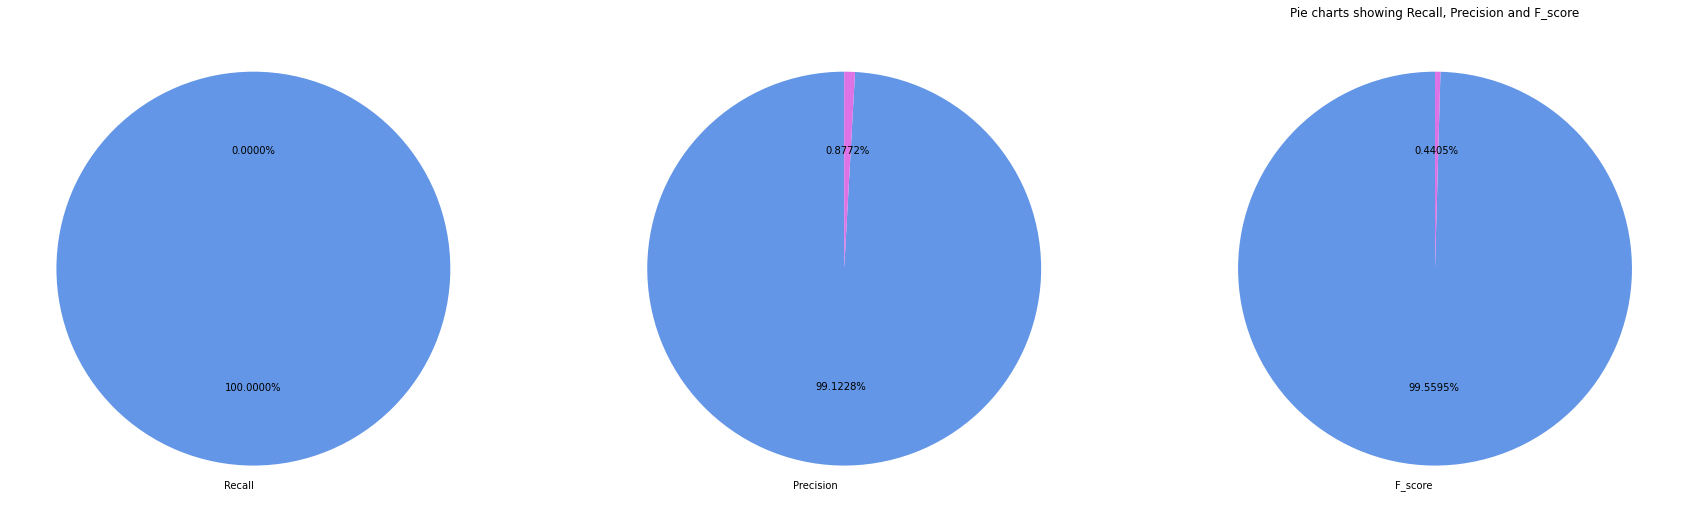

In [ ]:
#@title <font color="#18CF68">4.2) Recall, precision and F_score results
cell_id = 8
if tracker >= (cell_id - 1):
  recall = true_positives/(true_positives + false_negatives)
  recall_labels = ["Recall", " "]
  recall_sections = [recall, 1 - recall]

  precision = true_positives/(true_positives + false_positives)
  prec_labels = ["Precision", " "]
  prec_sections = [precision, 1 - precision]

  f_score = 2 * ((precision * recall)/(precision + recall))
  f_labels = ["F_score", " "]
  f_sections = [f_score, 1 - f_score]

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
  colors = ["#6396e6", "#de73e6"]

  axes[0].pie(recall_sections, 
          labels=recall_labels, 
          colors=colors, 
          startangle=90,
          autopct='%1.4f%%')
  axes[1].pie(prec_sections, 
          labels=prec_labels, 
          colors=colors,
          startangle=90, 
          autopct='%1.4f%%')
  axes[2].pie(f_sections, 
          labels=f_labels, 
          colors=colors, 
          startangle=90, 
          autopct='%1.4f%%')

  plt.title("Pie charts showing Recall, Precision and F_score")
  tracker = cell_id
else:
  tracker_err_msg(tracker, cell_id)

In [ ]:
#@title <font color="#18CF68">4.3) Display M and U values
cell_id = 9
if tracker >= (cell_id - 1):
  fields = ("Field", "Matches (M)", "Unmatches (U)")
  m_and_u = pd.DataFrame(columns=fields)
  for i in range(len(em_p_gamma_k_m)):
    m_and_u.loc[i] = (em_p_gamma_k_m[i][1], em_p_gamma_k_m[i][3], em_p_gamma_k_u[i][3])
  table_1 = m_and_u.style.format({"Matches (M)": "{:.4f}",
                                "Unmatches (U)": "{:.4f}"})\
                        .hide_index()\
                        .set_properties(**{'text-align': 'left'})
  table_1 = table_1.set_table_styles(
      [dict(selector = 'th', props=[('text-align', 'left')])])
  display(table_1)
  tracker = cell_id
else:
  tracker_err_msg(tracker, cell_id)

Field,Matches (M),Unmatches (U)
first_name,0.9283,0.0036
last_name,0.9528,0.0050
gender,1.0000,0.4984
dob,0.9888,0.0431
city,0.9988,0.0454
phone_number,0.9960,0.0241
national_id,0.9945,0.0012


In [ ]:
#@title <font color="#18CF68">4.4) Update data to a Google Spreadsheet
cell_id = 10
if tracker >= (cell_id - 1): 
  auth.authenticate_user()
  gc = gspread.authorize(GoogleCredentials.get_application_default())

  sh = gc.create('Fastlink Dedupe: Run {0}'.format(run_count))
  ws = sh.add_worksheet(title="Results", rows="100", cols="100")
  sh.del_worksheet(sh.sheet1)
  ws.update([l_and_r.columns.values.tolist()] + l_and_r.values.tolist())

  ws = sh.add_worksheet(title="Configuration and Performance", rows="10", cols="20")
  ws.update("A1:K1", [["True Positives", "False Positives", "True Negatives", 
                      "False Negatives", "Precision", "Recall", "F Score", 
                      "String Distance Method", "Cut.a", "Cut.p", "Parameters excluded"]])
  ws.update("A2:K2", [[true_positives, false_positives, true_negatives, 
                      false_negatives, precision, recall, f_score, 
                      string_distance, cut_a, cut_p, param_exclde_str]])

  ws = sh.add_worksheet(title="M and U values", rows="30", cols="10")
  ws.update([m_and_u.columns.values.tolist()] + m_and_u.values.tolist())
  run_count = run_count + 1
  tracker = cell_id
else:
  tracker_err_msg(tracker, cell_id)
